<a href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_02_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-Encoder to process spike waveforms

This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.


In [1]:
from pathlib import Path
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

try:
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    !pip install -q kaggle
    plt.style.use('dark_background')
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")


import tensorflow as tf
from indl import turbo_cmap
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

TensorFlow 2.x selected.


Saving kaggle.json to kaggle.json
Cloning into 'IntracranialNeurophysDL'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1260 (delta 78), reused 42 (delta 23), pack-reused 1127
Receiving objects: 100% (1260/1260), 317.96 MiB | 38.68 MiB/s, done.
Resolving deltas: 100% (755/755), done.
Checking out files: 100% (93/93), done.


In [2]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'vae_wf'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download -d guilmer/primate-pfc-spike-waveforms 
    print("Finished downloading. Now extracting contents...")
    data_path = Path('primate-pfc-spike-waveforms.zip')
    import zipfile
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(datadir)
    data_path.unlink()
    print("Finished extracting data.")
else:
    print("Data directory found. Skipping download.")

 85% 84.0M/98.6M [00:03<00:00, 22.6MB/s]
100% 98.6M/98.6M [00:03<00:00, 30.2MB/s]
Finished downloading. Now extracting contents...
Finished extracting data.


## Load data and plot a few examples to see what we're up against. 

This data was recorded from a 96 channel Utah Array in the lateral prefrontal cortex of a macaque monkey. 

Each channel was manually thresholded to remove invalid channels and to try to obtain the best isolated waveforms. 

Each waveform is 48 samples long, sampled  @ 30kHz for a duration of 1.6 ms. 

The data might still contain artefacts and some invalid waveforms.  

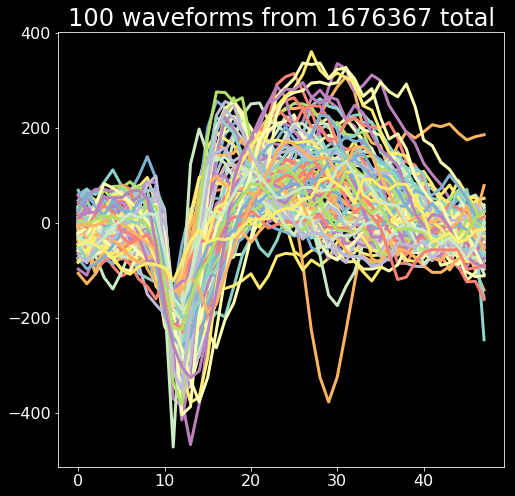

In [3]:
# Load data, convert to float-32 and add extra dim for tensorflow convolution layers
wf = np.load(os.path.join(datadir, 'waveforms.npy')).astype(np.float32)
wf = wf.reshape(wf.shape[0], wf.shape[1], 1)

# Plot 100 randomly selected waveforms
n_to_plot = 100
plt.figure(figsize=(8, 8))
plt.plot(wf[np.random.randint(0, wf.shape[0], n_to_plot),:, 0].T)
plt.title(str(n_to_plot) + ' waveforms from ' + str(wf.shape[0]) + ' total');

### Data pre-processing for deep learning

It's usually a good idea to normalize your data in some way to restrict it's range roughly around $\pm 1$. 

We'll z-score. 

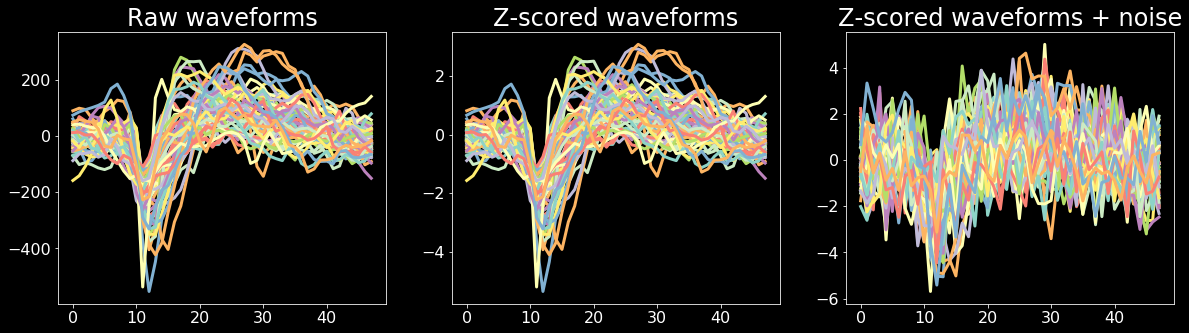

In [4]:
# Z-scoring the data
wf_mean = np.mean(wf)
wf_sd = np.std(wf)

z_wf = (wf-wf_mean) / wf_sd

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(wf[::30000, :, 0].T)
plt.title('Raw waveforms')
plt.subplot(132)
plt.plot(z_wf[::30000, :, 0].T)
plt.title('Z-scored waveforms')
plt.subplot(133)
plt.plot((z_wf[::30000, :, 0] + np.random.randn(z_wf[::30000, :, 0].shape[0],
                                                z_wf[::30000, :, 0].shape[1])).T)
plt.title('Z-scored waveforms + noise');

Even if we are not classifying the data, we need a validation set to make sure we are not over-fitting. We'll use 10000 randomly selected waveforms. 

In [0]:
# Validation set creation
n_test_waveforms = 10000
valid_idx = np.random.randint(0, z_wf.shape[0], n_test_waveforms)
valid_set = z_wf[valid_idx,:,:]

# Take only 50 000 waveforms to speed up training
n_train_waveforms = 50000
train_set = np.delete(z_wf, valid_idx, axis=0)
train_set = train_set[np.random.randint(0,train_set.shape[0], n_train_waveforms),:,:]


### Model Creation

In [0]:
# Model definition
# Fully annotated in VAE_SS_Validation notebook
# Data augmentation has been left out for now. 
class betaCVAE(tf.keras.Model):
    def __init__(self,
                 latent_dim=2,  # Size of bottleneck.
                 beta=0.,  # 0 (default) means this is AE, not VAE
                 learning_rate=1e-2,
                 capacity=0.):

        super(betaCVAE, self).__init__()

        # Save our parameter as instance attributes.
        self.latent_dim = latent_dim
        self.beta = beta
        self.learning_rate = learning_rate
        self.capacity = capacity

        if self.beta > 0.:
            self.is_VAE = True
        else:
            self.is_VAE = False

            
        # Define the Encoder
        self.encoder_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(48, 1)),
            tf.keras.layers.Conv1D(filters=25, kernel_size=5, strides=1,
                                   activation=tf.nn.elu, padding='same'),  # output => 48 x 25
            tf.keras.layers.MaxPool1D(pool_size=2),                        # output => 24 x 25
            tf.keras.layers.Conv1D(filters=25, kernel_size=3, strides=1,
                                   activation=tf.nn.elu, padding='same'),  # output => 24 x 25
            tf.keras.layers.MaxPool1D(pool_size=2),                        # output => 12 x 25    
            tf.keras.layers.Conv1D(filters=25, kernel_size=3, strides=1,
                                   activation=tf.nn.elu, padding='same'),  # output => 12 x 25
            tf.keras.layers.MaxPool1D(pool_size=2),                        # output => 6 x 25
            tf.keras.layers.Flatten(),                                     # 150 x 1
            tf.keras.layers.Dense(50, activation=tf.nn.elu),               # 50 x 1
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])


        # Define the Decoder
        self.decoder_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(50, activation=tf.nn.elu),
            tf.keras.layers.Dense(150, activation=tf.nn.elu),
            tf.keras.layers.Reshape(target_shape=(6, 25)),
            tf.keras.layers.UpSampling1D(size=2),                          # 12 x 25
            tf.keras.layers.Conv1D(filters=25, kernel_size=3, strides=1,
                                   activation=tf.nn.elu, padding='same'),  # 12 x 25
            tf.keras.layers.UpSampling1D(size=2),                          # 24 x 25
            tf.keras.layers.Conv1D(filters=25, kernel_size=3, strides=1,
                                   activation=tf.nn.elu, padding='same'),  # 24 x 25
            tf.keras.layers.UpSampling1D(size=2),                          # 48 x 25
            tf.keras.layers.Conv1D(filters=25, kernel_size=5, strides=1,
                                   activation=tf.nn.elu, padding='same'),  # 48 x 25
            tf.keras.layers.Conv1D(filters=1, kernel_size=1, strides=1),   # 48 x 1
        ])
    
    # Encoding converts input to set of means and set of logvars
    def encode(self, x):
        mean, logvar = tf.split(self.encoder_model(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder_model(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random_normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return (eps * tf.exp(logvar * .5)) + mean

    def compute_loss(self, x, noisy_x):
        # Encoder part of the network
        if noisy_x is None:
            mean, log_var = self.encode(x)
        else:
            mean, log_var = self.encode(noisy_x)

        if self.is_VAE:
            z = self.reparameterize(mean, log_var)
        else:
            z = mean

        # Decoder
        x_decoded = self.decode(z)

        # MSE
        recons_loss = tf.reduce_sum(tf.math.squared_difference(x, x_decoded), axis=1)
        recons_loss = tf.reduce_mean(recons_loss)

        # KLD
        latent_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
        latent_loss = tf.reduce_mean(latent_loss)

        return tf.reduce_mean(recons_loss + self.beta * (tf.math.abs(latent_loss - self.capacity))), recons_loss, latent_loss


    def compute_gradients(self, x, noisy_x):
        with tf.GradientTape() as tape:
            loss, _, _ = self.compute_loss(x, noisy_x)
        return tape.gradient(loss, self.trainable_variables), loss

    @staticmethod
    def apply_gradients(optimizer, gradients, variables):
        optimizer.apply_gradients(zip(gradients, variables))

# Implementation 1 

For now we'll simply create the model by calling the model creation function by using its default values. This is because our AE model has a few tricks up its sleeve and we haven't seen all the possible uses and parameters yet. 

The important parameters are: 

**ADD_NOISE**

> Setting this to `True` will add normally distributed noise to the data ($\mu = 0; SD = 1$). `False` will use the original data. Considering that the spike waveforms are already noisy, both approaches work well. Try either to see how good the model is. 

**Mini-batch size**

> Since our data is quite small (only 48 samples) we can use large batch sizes without fear of running out of GPU memory, but some caution should be used for mini-batch sizes [greater than
512](https://arxiv.org/abs/1606.02228). We can play with the values to trade-off between performance (large values) and model accuracy (small values), as larger batch sizes tend to make the model less precise. 

> For the sake of speed, we will use a high value of 1024, but feel free to try other values. Setting it to 2048 increases speed but decreases the convergence rate of the model. These values work well on Google Colab, but if you run into memory errors on your local machine, decrease the batch size. 

**Learning-rate**

> How "fast" our model learns. Since our batch size is fairly large we can use a large learning rate too. But increasing it further to `1e-1` creates instability and results in `NaN` values. 


**Training epochs**

> The number of passes through the entire training data. We'll run the validation set after each epoch. 
> If you decreased the batch size, you can train for less epochs to speed everything up. Learning is quite slow at the latter epochs. 

In [0]:
# Model parameters
# setting this to True will add a normal gaussian noise to the z_scored data
# False will train only on the "clean" z_scored waveforms
ADD_NOISE = False  

BATCH_SIZE = 1024  
LEARNING_RATE = 1e-2
EPOCHS = 25

# Model Creation
model = betaCVAE(learning_rate=LEARNING_RATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Dataset creation
TRAIN_BUF = train_set.shape[0]
VALID_BUF = valid_set.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_set).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_set).shuffle(VALID_BUF).batch(BATCH_SIZE)

# Trackers
train_loss = []
valid_loss = []
train_time = []
valid_time = []

### Run functions

This AE model is a bit more "hands-on" than the previous CNN we used because we'll later need to access some of the inner functions to compute the loss and gradients. 

Instead of using `model.fit(...)` we will directly call the `model.compute_gratients()` and `model.apply_gradients()` functions. These aren't default tensorflow model functions, they were manually created for this purpose. 

In [0]:
import time

def train_model(add_noise, out_losses=False):
    for epoch in range(1, EPOCHS + 1):

        temp_loss = []
        start_time = time.time()

        # iterator generator that randomizes the training datasets
        for train_x in train_dataset:
            if add_noise:
                gradients, loss = model.compute_gradients(train_x, train_x + tf.random.normal(shape=train_x.shape))
            else:
                gradients, loss = model.compute_gradients(train_x, None)

            model.apply_gradients(optimizer, gradients, model.trainable_variables)
            temp_loss.append(loss)

        train_loss.append(np.mean(temp_loss))
        train_time.append(time.time()-start_time)

        temp_loss = []
        for valid_x in valid_dataset:
            if add_noise:
                temp, recon, latent = model.compute_loss(valid_x, valid_x + tf.random.normal(shape=valid_x.shape))
                temp_loss.append(temp.numpy())
            else:
                temp, recon, latent = model.compute_loss(valid_x, None)
                temp_loss.append(temp.numpy())
                
            if out_losses:
                recon_loss.append(recon)
                latent_loss.append(latent)

        valid_loss.append(np.mean(temp_loss))

        if epoch % 1 == 0:
            print('Epoch: {} / {}, Train set loss: {}, Test set loss: {}, '
              'time elapsed for current epoch {}'.format(epoch, EPOCHS,
                                                         train_loss[-1], 
                                                         valid_loss[-1],
                                                        train_time[-1]))

# Randomly sample N waveforms from the entire datasets        
def get_examples(n_examples, add_noise):
    examples = z_wf[np.random.randint(0, z_wf.shape[0], n_examples)]
    if add_noise: 
        examples += np.random.rand(examples.shape[0], examples.shape[1], examples.shape[2])
    return examples


### (Finally) Run the training

In [9]:
print('Add noise = ' + str(ADD_NOISE))
train_model(ADD_NOISE)

Add noise = False
Epoch: 1 / 25, Train set loss: 16.539661407470703, Test set loss: 8.614017486572266, time elapsed for current epoch 6.0446202754974365
Epoch: 2 / 25, Train set loss: 8.001607894897461, Test set loss: 7.8163862228393555, time elapsed for current epoch 1.9833571910858154
Epoch: 3 / 25, Train set loss: 7.601985454559326, Test set loss: 7.558896064758301, time elapsed for current epoch 1.953847885131836
Epoch: 4 / 25, Train set loss: 7.3876824378967285, Test set loss: 7.470172882080078, time elapsed for current epoch 1.945967674255371
Epoch: 5 / 25, Train set loss: 7.247780799865723, Test set loss: 7.422715187072754, time elapsed for current epoch 1.9875869750976562
Epoch: 6 / 25, Train set loss: 7.239377498626709, Test set loss: 7.2614898681640625, time elapsed for current epoch 1.9654779434204102
Epoch: 7 / 25, Train set loss: 7.1605610847473145, Test set loss: 7.235498905181885, time elapsed for current epoch 1.9035530090332031
Epoch: 8 / 25, Train set loss: 7.05994415

The loss function might still apear high at ~6.7 for both training and testing sets (`ADD_NOISE=False`) but we use the mean sum of squared residuals so: 

$\sqrt{(6.7 / 48)} \approx .37$

If we look at what that represents on a real waveform. 


Average error per point: 0.3649839743052901


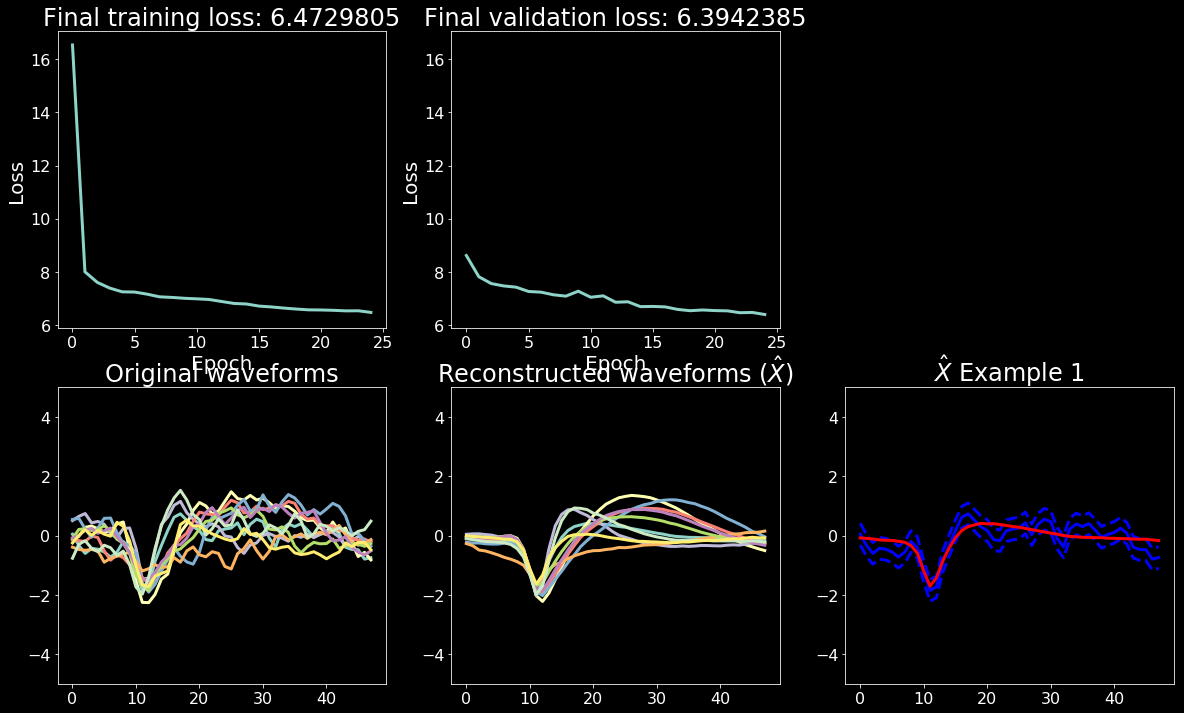

In [10]:
def plot_loss():
    # Plot Loss results
    fig = plt.figure(figsize=(20,12))
    ax = plt.subplot(231)
    plt.plot([x for x in train_loss])
    plt.title('Final training loss: ' + str(train_loss[-1]))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.subplot(232, sharey=ax)
    plt.plot([x for x in valid_loss])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final validation loss: ' + str(valid_loss[-1]))

    # Plot reconstruction examples
    n_to_plot = 10

    examples = get_examples(n_to_plot, ADD_NOISE)

    m, logvar = model.encode(examples)
    x_hat = model.decode(m)

    lims = (-5,5)
    diffs = np.sqrt(valid_loss[-1]/examples.shape[1])
    print('Average error per point: ' + str(diffs))
    ax = plt.subplot(234)
    plt.plot(examples.squeeze().T)
    plt.title('Original waveforms')
    plt.ylim(lims)
    plt.subplot(235, sharey=ax)
    plt.plot(x_hat.numpy().squeeze().T)
    plt.title('Reconstructed waveforms ($\hat{X}$)')
    plt.subplot(236, sharey=ax)
    plt.plot(examples[0,:,:].squeeze(), 'b')
    plt.plot(examples[0,:,:].squeeze()-diffs, '--b')
    plt.plot(examples[0,:,:].squeeze()+diffs, '--b')
    plt.plot(x_hat[0,:,:].numpy().squeeze(), 'r')
    plt.title('$\hat{X}$ Example 1')

plot_loss()

We can see that the above reconstructed waveforms seem pretty good. Which is expected since it is a very simple task. 

But keep in mind we have a very narrow bottleneck!

In [11]:
model.latent_dim

2

### Let's compare with PCA

Using the same script as above but for 1000 spikes. 

The color scale follows the values of the first PC. 

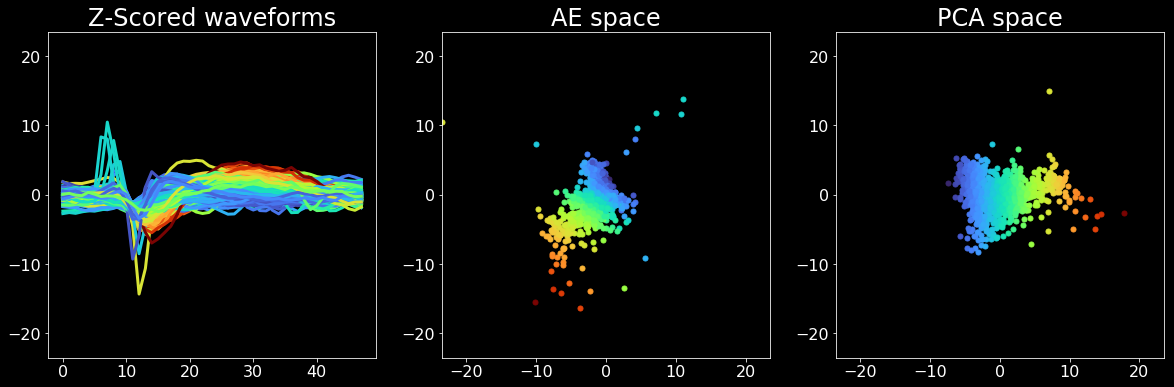

In [17]:
def pca_comp():
    # Plot reconstruction examples
    # Our AE
    n_dim = model.latent_dim  # 2 by default

    n_to_plot = 1000
    examples = get_examples(n_to_plot, ADD_NOISE)
    model_out, _ = model.encode(examples)

    # PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_dim)
    pca_out = pca.fit_transform(examples.squeeze())

    min_pca = np.min(pca_out[:,0])
    max_pca = np.max(pca_out[:,0])

    # Plot results
    lims = np.max(
            (np.abs(np.min(pca_out)), np.abs(np.max(pca_out)),
             np.abs(np.min(model_out)), np.abs(np.max(model_out))))

    fig = plt.figure(figsize=(20,6))
    ax1 = plt.subplot(131, ylim=(-lims, lims), title='Z-Scored waveforms')
    ax2 = plt.subplot(132, xlim=(-lims, lims), sharey=ax1, title='AE space')
    ax3 = plt.subplot(133, sharex=ax2, sharey=ax2, title='PCA space')

    for idx, ex in enumerate(examples.squeeze()):
        colors = turbo_cmap((pca_out[idx,0] - np.min(pca_out))/(np.abs(np.min(pca_out))+np.max(pca_out)))
        ax1.plot(ex, color=colors)
        ax2.plot(model_out.numpy()[idx,0],model_out.numpy()[idx,1], '.', color=colors)
        ax3.plot(pca_out[idx,0],pca_out[idx,1], '.', color=colors)
        
    return model_out, pca_out, pca   

model_out, pca_out, pca = pca_comp()

The AE latent space is more spread out than the PCA one, and it seems that the two PC dimensions are mingled in the AE representations.

The AE feature space is also quite discontinuous meaning that when randomly sampling points to generate waveforms, there is a greater probability of sampling from an empty region which could yield an unrealistic or distorted waveform. 

Let generate a few and see. 


VAE generating in the range: 
 x:-23.501959 to 10.994134
 y:-16.306768 to 13.856947
VAE generated samples : 
 [[-10.49220703 -10.84718126]
 [ -4.66140474   2.1642874 ]
 [ -1.01604866   3.6592688 ]
 [  1.47775058  12.9574056 ]
 [  7.37803984  -7.02719009]
 [-23.46154839  -7.37581405]
 [ -5.84681385   7.36023902]
 [ -1.1253535    7.03825855]
 [  6.10985877  -1.51550256]
 [-20.03234799 -15.48221429]]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

PCA generating in the range: 
 x:-7.4603076 to 17.836647
 y:-7.4603076 to 14.892467
VAE generated samples 

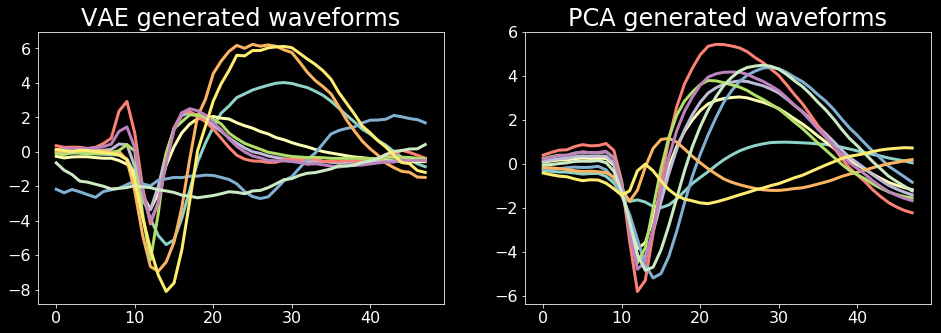

In [18]:
def wave_generation(model_out, pca_out, pca):
  # Model_out feature space
    min_model_x = np.min(model_out.numpy()[:,0])
    max_model_x = np.max(model_out.numpy()[:,0])
    min_model_y = np.min(model_out.numpy()[:,1])
    max_model_y = np.max(model_out.numpy()[:,1])
    print('VAE generating in the range: \n x:' +
        str(min_model_x) + ' to ' + str(max_model_x) + '\n y:' +
        str(min_model_y) + ' to ' + str(max_model_y))

    n_to_generate=10
    random_latent_features = np.random.rand(n_to_generate, 2)
    model_latent = random_latent_features * np.array(((np.abs(min_model_x) + np.abs(max_model_x)),(np.abs(min_model_y) + np.abs(max_model_y))))
    model_latent -= np.array((np.abs(min_model_x), np.abs(min_model_y)))
    print('VAE generated samples : \n ' + str(model_latent) + '\n')

    x_hat = model.decode(model_latent)

    fig = plt.figure(figsize=(16,5))
    plt.subplot(121)
    plt.plot(x_hat.numpy().squeeze().T)
    plt.title('VAE generated waveforms');

    # Repeat for PCA
    min_pca_x = np.min(pca_out[:,0])
    max_pca_x = np.max(pca_out[:,0])
    min_pca_y = np.min(pca_out[:,1])
    max_pca_y = np.max(pca_out[:,1])
    print('PCA generating in the range: \n x:' +
        str(min_pca_x) + ' to ' + str(max_pca_x) + '\n y:' +
        str(min_pca_x) + ' to ' + str(max_pca_y))

    pca_latent_features = random_latent_features * np.array(((np.abs(min_pca_x) + np.abs(max_pca_x)),(np.abs(min_pca_y) + np.abs(max_pca_y))))
    pca_latent_features -= np.array((np.abs(min_pca_x), np.abs(min_pca_y)))
    print('VAE generated samples : \n ' + str(pca_latent_features) + '\n')

    pca_hat = pca.inverse_transform(pca_latent_features)

    plt.subplot(122)
    plt.plot(pca_hat.T)
    plt.title('PCA generated waveforms');
    return [min_model_x, max_model_x, min_model_y, max_model_y], [min_pca_x, max_pca_x, min_pca_y, max_pca_y]
  
min_max_model, min_max_pca = wave_generation(model_out, pca_out, pca)

### Plot individual features



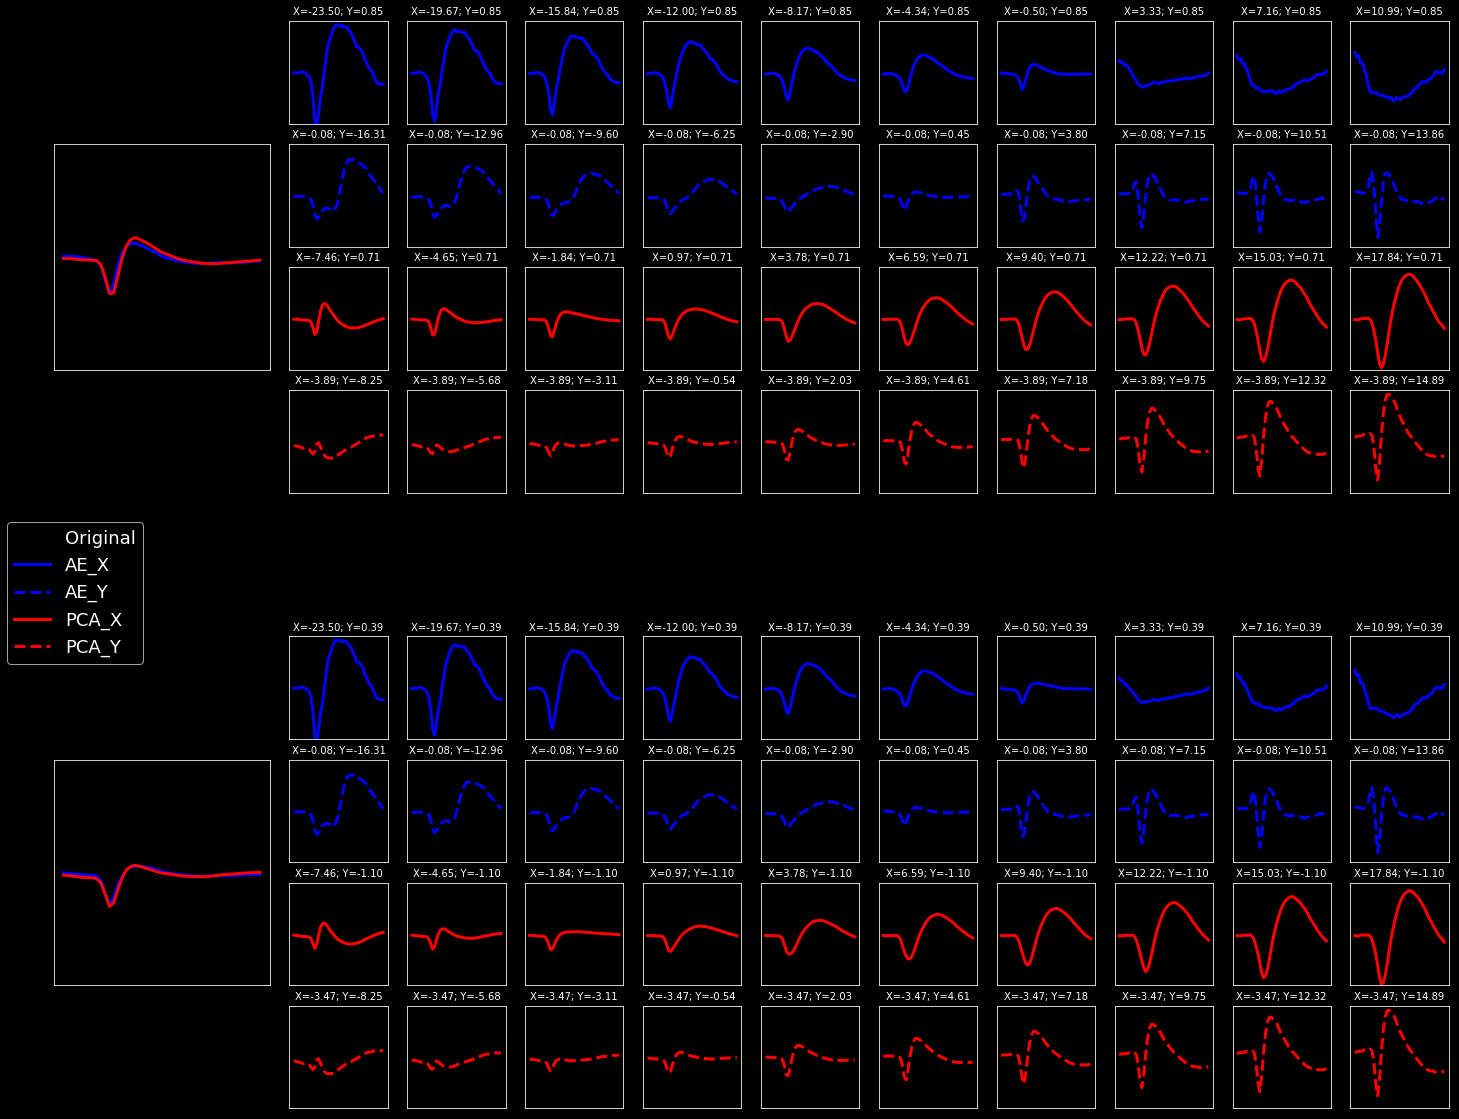

In [22]:
def plot_features(min_max_model, min_max_pca):
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='k'),
                  Line2D([0], [0], color='b'),
                  Line2D([0], [0], color='b', linestyle='--'),
                  Line2D([0], [0], color='r'),
                  Line2D([0], [0], color='r', linestyle='--')]
    n_lin_space = 10

    fig = plt.figure(figsize=(25,20))
    gs = fig.add_gridspec(9,n_lin_space + 2)

    subs = [fig.add_subplot(gs[1:3,0:2])]
    subs.append(fig.add_subplot(gs[6:8,0:2]))

    model_x_range = np.linspace(min_max_model[0], min_max_model[1], n_lin_space)
    model_y_range = np.linspace(min_max_model[2], min_max_model[3], n_lin_space)
    pca_x_range = np.linspace(min_max_pca[0], min_max_pca[1], n_lin_space)
    pca_y_range = np.linspace(min_max_pca[2], min_max_pca[3], n_lin_space)

    # get N examples
    examples = get_examples(2, ADD_NOISE)

    model_out, _ = model.encode(examples)
    pca_out = pca.transform(examples.squeeze())

    for sub, ex in enumerate(examples): 

        subs[sub].plot(ex,'k')
        subs[sub].plot(model.decode(tf.reshape(model_out[sub,:], (1,2))).numpy().squeeze(),'b')
        subs[sub].plot(pca.inverse_transform(pca_out[sub,:]),'r')

        for idx in range(n_lin_space):
            fig.add_subplot(gs[0+(5*sub),idx+2])
            plt.plot(model.decode(np.array([model_x_range[idx], model_out[sub,1].numpy()]).reshape(1,2)).numpy().squeeze(), 'b')
            plt.title('X={:.2f}; Y={:.2f}'.format(model_x_range[idx], model_out[sub,1].numpy()),
                     fontsize=10)

            fig.add_subplot(gs[1+(5*sub),idx+2])
            plt.plot(model.decode(np.array([model_out[sub,0].numpy(), model_y_range[idx]]).reshape(1,2)).numpy().squeeze(), '--b')
            plt.title('X={:.2f}; Y={:.2f}'.format(model_out[sub,0].numpy(), model_y_range[idx]),
                     fontsize=10)

            fig.add_subplot(gs[2+(5*sub),idx+2])
            plt.plot(pca.inverse_transform(np.array([pca_x_range[idx], pca_out[sub,1]]).reshape(1,2)).T, 'r')
            plt.title('X={:.2f}; Y={:.2f}'.format(pca_x_range[idx], pca_out[sub,1]),
                     fontsize=10)

            fig.add_subplot(gs[3+(5*sub),idx+2])
            plt.plot(pca.inverse_transform(np.array([pca_out[sub,0], pca_y_range[idx]]).reshape(1,2)).T, '--r')
            plt.title('X={:.2f}; Y={:.2f}'.format(pca_out[sub,0], pca_y_range[idx]),
                     fontsize=10)

    fig.add_subplot(gs[4,0], frame_on=False, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
    plt.legend(custom_lines, ['Original', 'AE_X','AE_Y', 'PCA_X', 'PCA_Y'])

    for ax in fig.axes:
        ax.set_ylim((-6,6))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])

    
plot_features(min_max_model, min_max_pca)

# Implementation 2

### Possible to increase density in latent space? 

We can add a penalty term to our reconstruction loss function to force a specific latent representation. 

For example, we can force the latent variables to follow a unit Gaussian shape. ($\beta=1$)

Wich is a **Variational Auto-Encoder**.



If we re-run the cells above to re-plot, we see that the VAE latent representation is much more compact. This allows us to have a uniform latent space in order to generate believable waveforms. 




In [23]:
# Model parameters
BETA = 1.
BATCH_SIZE = 1024  
LEARNING_RATE = 1e-2
EPOCHS = 25

# Model Creation
model = betaCVAE(learning_rate=LEARNING_RATE, beta=BETA)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Dataset creation
TRAIN_BUF = train_set.shape[0]
VALID_BUF = valid_set.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_set).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_set).shuffle(VALID_BUF).batch(BATCH_SIZE)

# Trackers
train_loss = []
valid_loss = []
train_time = []
valid_time = []

train_model(ADD_NOISE)

Epoch: 1 / 25, Train set loss: 21.298236846923828, Test set loss: 12.54015827178955, time elapsed for current epoch 2.2050235271453857
Epoch: 2 / 25, Train set loss: 11.853209495544434, Test set loss: 11.621870040893555, time elapsed for current epoch 2.0682291984558105
Epoch: 3 / 25, Train set loss: 11.414865493774414, Test set loss: 11.380902290344238, time elapsed for current epoch 2.0616629123687744
Epoch: 4 / 25, Train set loss: 11.268342018127441, Test set loss: 11.671659469604492, time elapsed for current epoch 2.08610463142395
Epoch: 5 / 25, Train set loss: 11.516919136047363, Test set loss: 11.484487533569336, time elapsed for current epoch 2.06148099899292
Epoch: 6 / 25, Train set loss: 11.06816291809082, Test set loss: 11.157600402832031, time elapsed for current epoch 2.071967840194702
Epoch: 7 / 25, Train set loss: 11.029805183410645, Test set loss: 11.380914688110352, time elapsed for current epoch 2.0600762367248535
Epoch: 8 / 25, Train set loss: 10.98908805847168, Test 

Average error per point: 0.4726821219769533
VAE generating in the range: 
 x:-6.3305616 to 3.2659254
 y:-5.399007 to 3.4729476
VAE generated samples : 
 [[-1.08885557 -2.32901655]
 [-5.04466747  2.88123096]
 [-0.51141026 -0.08717613]
 [-5.84705594 -5.23943902]
 [-3.04271164 -1.88035462]
 [ 0.12146042 -0.16430612]
 [-3.79992842 -4.94127013]
 [-3.39561654 -4.09803987]
 [ 2.28721976  0.04081468]
 [-2.25219332 -4.05182676]]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

PCA generating in the range: 
 x:-6.367013 to 13.095197
 y:-6.367013 to 8.476072
VA

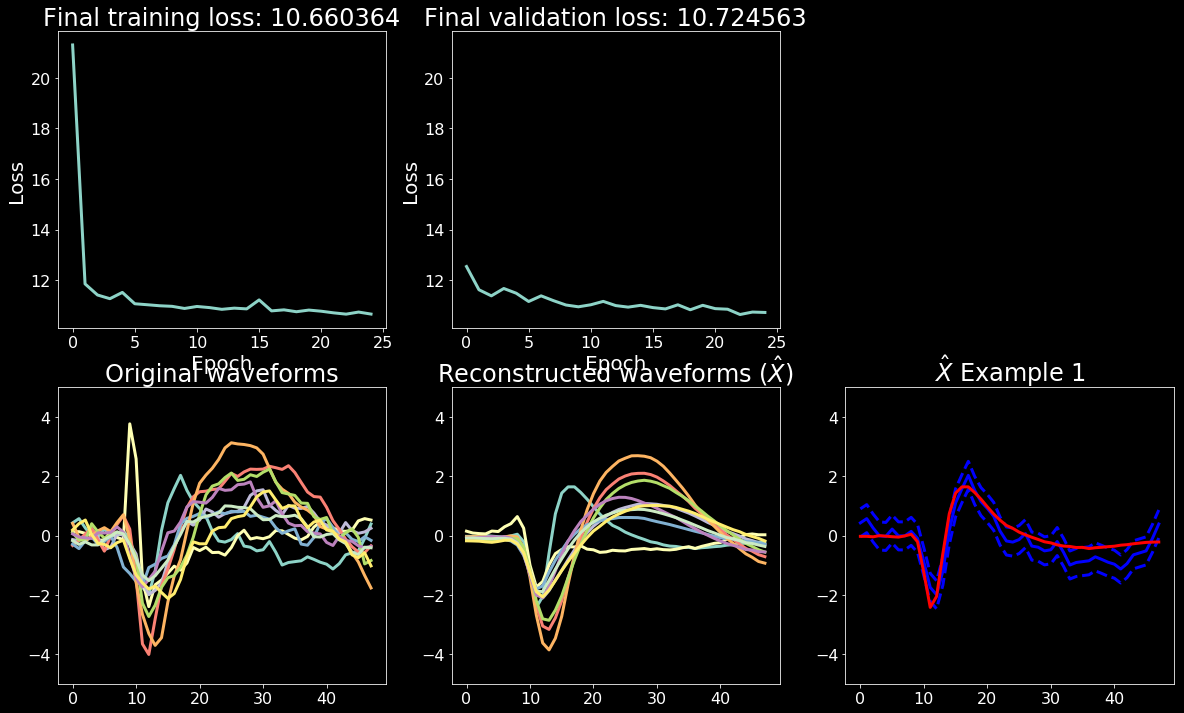

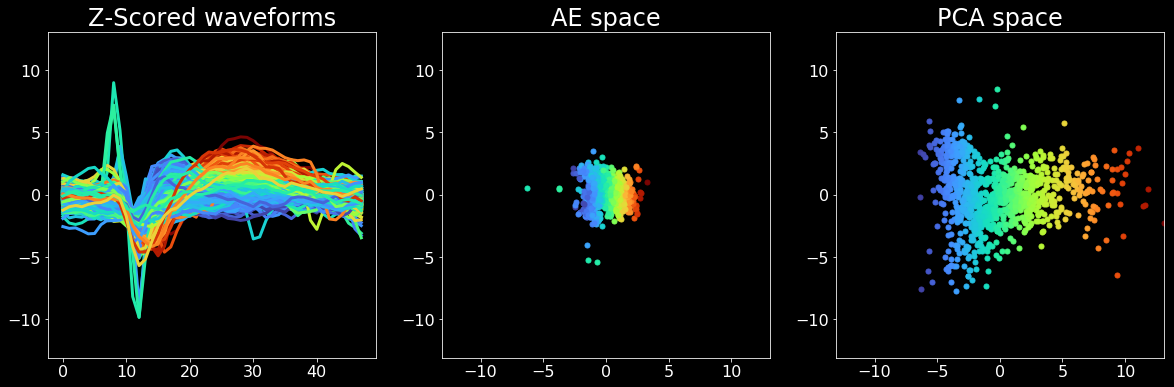

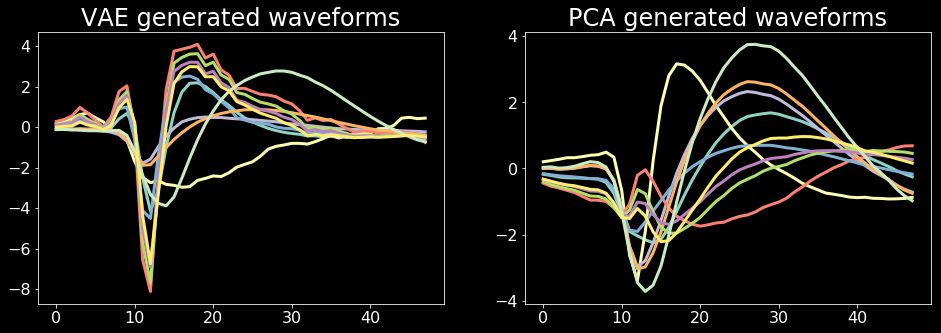

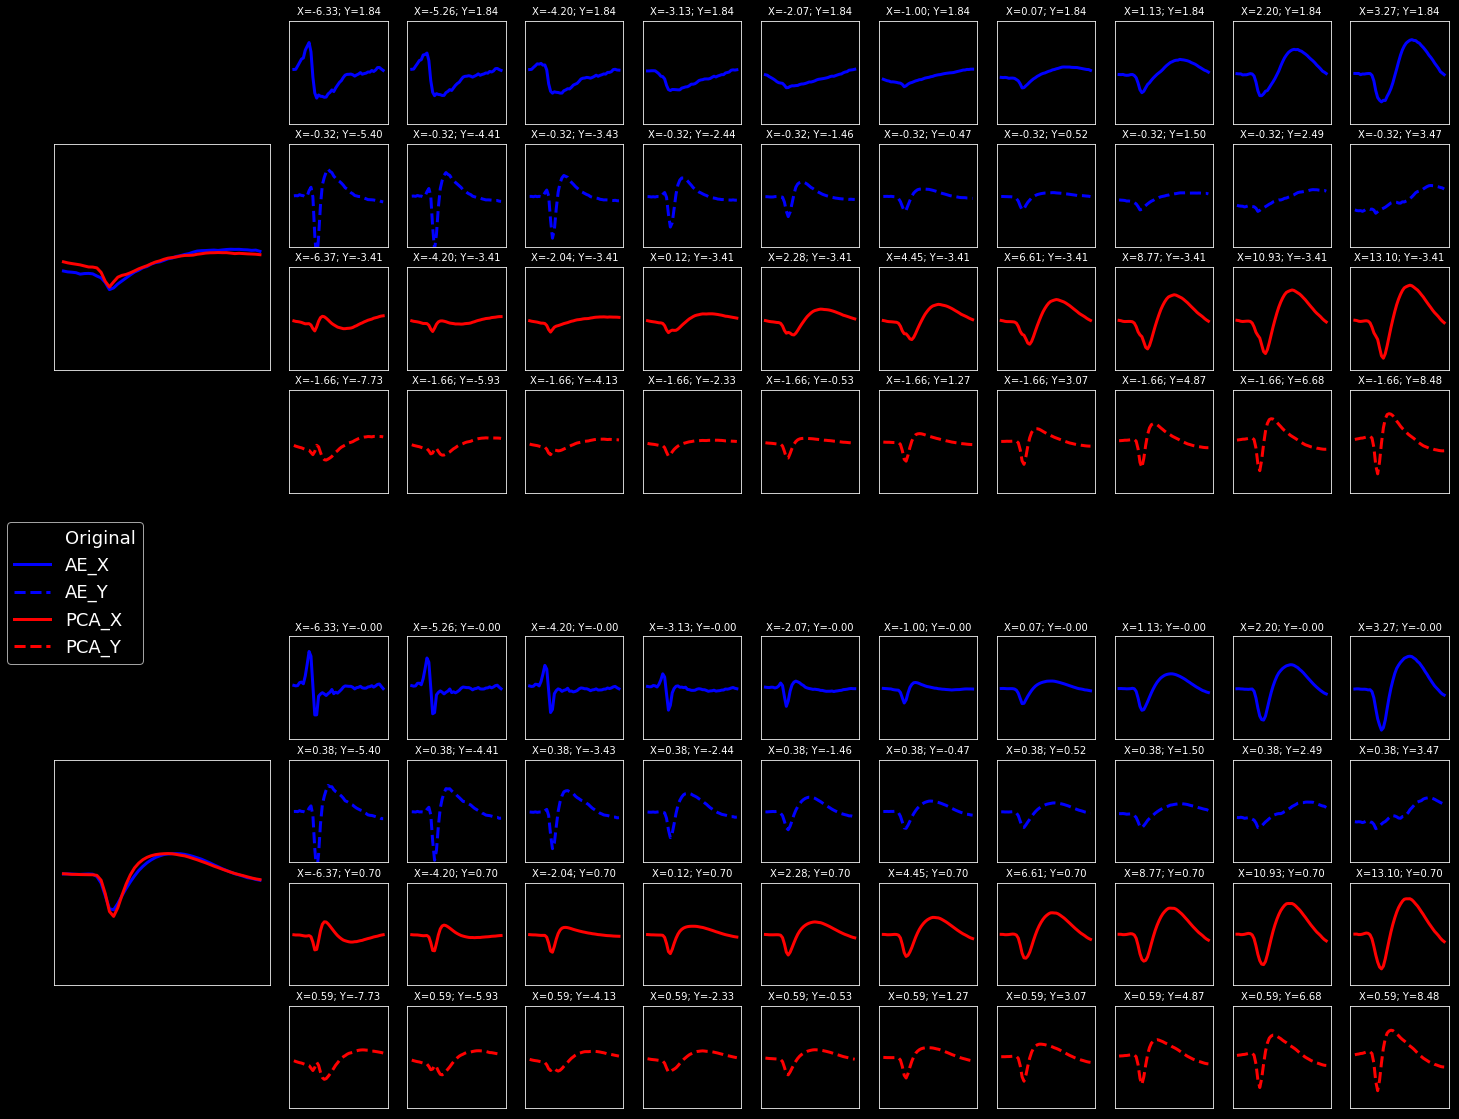

In [24]:
# to re-run the above plots
plot_loss()
model_out, pca_out, pca = pca_comp()
min_max_model, min_max_pca = wave_generation(model_out, pca_out, pca)
plot_features(min_max_model, min_max_pca)

# Implementation 3

In this section we will use the capacity parameter and linearly increase it with training to for the network to learn disentangled representations. 

This is taken from [Burgess et al.,2018](http://arxiv.org/abs/1804.03599).

In a nutshell, by using a large $\beta$ value, the network prioritizes the KL divergence term of the loss function and doesn't learn to reconstruct the data at the beginning of training (i.e. capacity = 0). It basically models the data mean. 

The capacity term is added to the loss function where: 

$Loss = Reconstruction \space loss + \beta (KL \space divergence - capacity)$

This means that when we increase the capacity of the network, we slowly reduce the importance of the KL divergence term, allowing the network to slowly increase it's reconstruction capacity. 

The followin cell plots the latent space of a few example waveforms. Throught training we can see that the network first separates the data along one dimension, and later along the second one. 

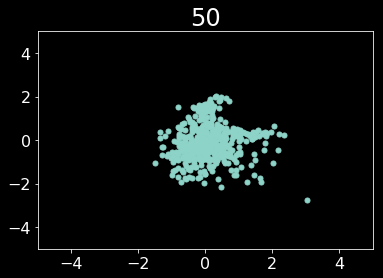

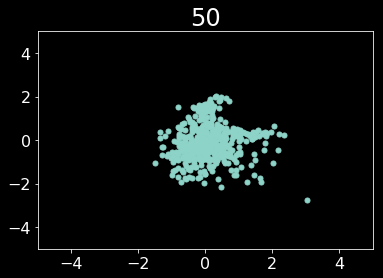

In [25]:
from IPython import display
import time
# Model Creation
# Model parameters
ADD_NOISE = False 
BETA = 20.  # actually gamma parameter in the paper
CAPACITY_MAX = 2.
CAPACITY_ANN = 50
CAPACITY_STEP = 1

BATCH_SIZE = 1024  
LEARNING_RATE = 1e-2
EPOCHS = 1
model = betaCVAE(learning_rate=LEARNING_RATE, beta=BETA, capacity=0., latent_dim=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Dataset creation
TRAIN_BUF = train_set.shape[0]
VALID_BUF = valid_set.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_set).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_set).shuffle(VALID_BUF).batch(BATCH_SIZE)

# Trackers
train_loss = []
valid_loss = []
train_time = []
valid_time = []
recon_loss = []
latent_loss = []

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
line = ax.plot(0,0,'.')

n_to_plot = 500
examples = get_examples(n_to_plot, ADD_NOISE)

for x in range(CAPACITY_ANN+1):
    if x % CAPACITY_STEP == 0 and x > 0:
        model.capacity += CAPACITY_MAX / (CAPACITY_ANN / CAPACITY_STEP)
    
    train_model(ADD_NOISE, out_losses=True);
    capacity_trained = model.encode(examples)[0].numpy().squeeze()
    line[0].set_xdata(capacity_trained[:,0])
    line[0].set_ydata(capacity_trained[:,1])
    ax.set_title(str(x))
    display.clear_output()
    display.display(plt.gcf())
    time.sleep(.001) 
  

Average error per point: 0.4762573724544856
VAE generating in the range: 
 x:-1.8462415 to 2.293895
 y:-2.6562371 to 2.3238282
VAE generated samples : 
 [[-1.12680938e+00 -1.64195995e+00]
 [ 3.06833359e-02  2.70862034e-01]
 [-1.15201373e+00 -1.18137606e+00]
 [-5.27589665e-04  3.46454087e-01]
 [-5.92671280e-01 -2.09559672e+00]
 [-1.28568408e+00 -1.98386366e+00]
 [-1.43168826e+00 -1.65576366e+00]
 [-8.30552588e-01  1.23754186e+00]
 [-1.77433476e+00  1.86041215e+00]
 [ 1.32372706e-01  5.04386364e-01]]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

PCA

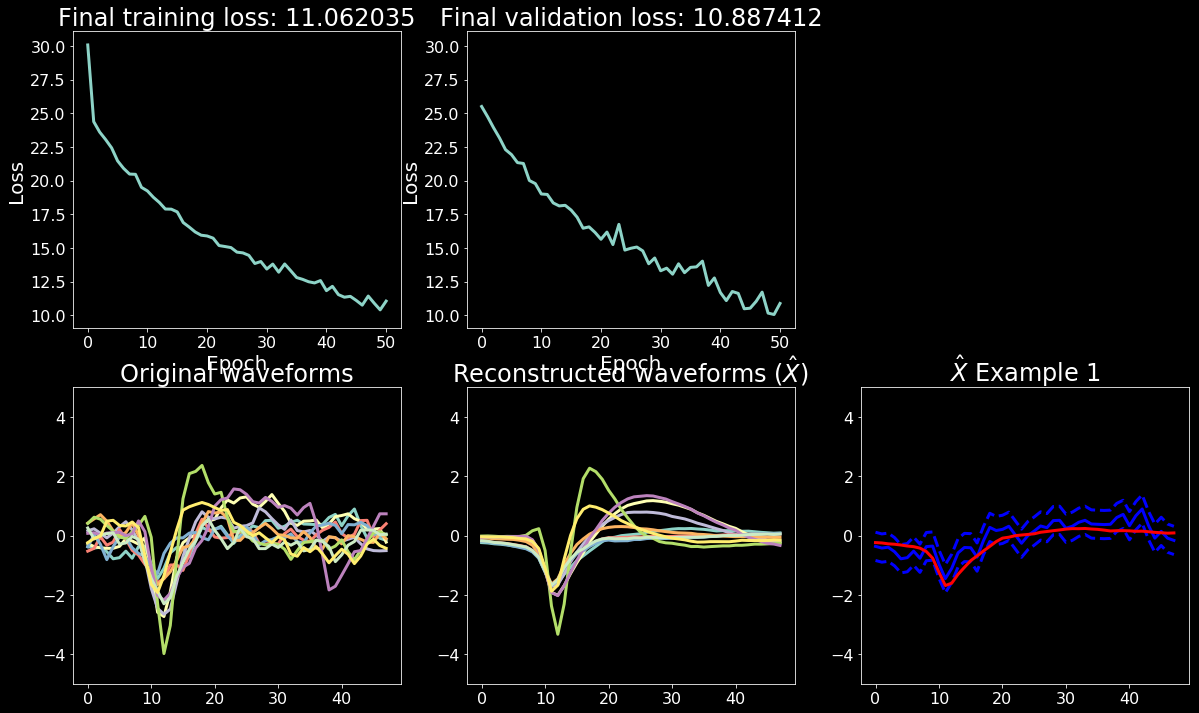

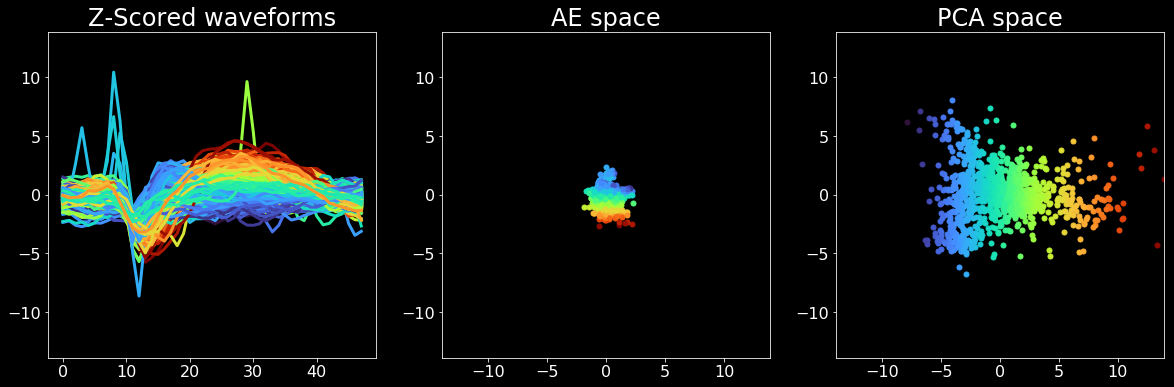

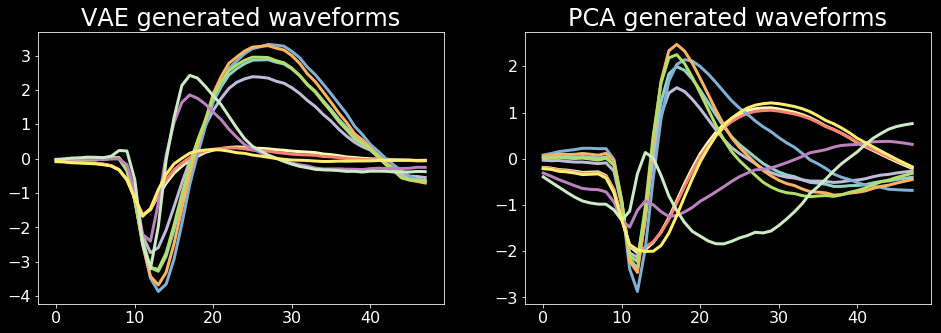

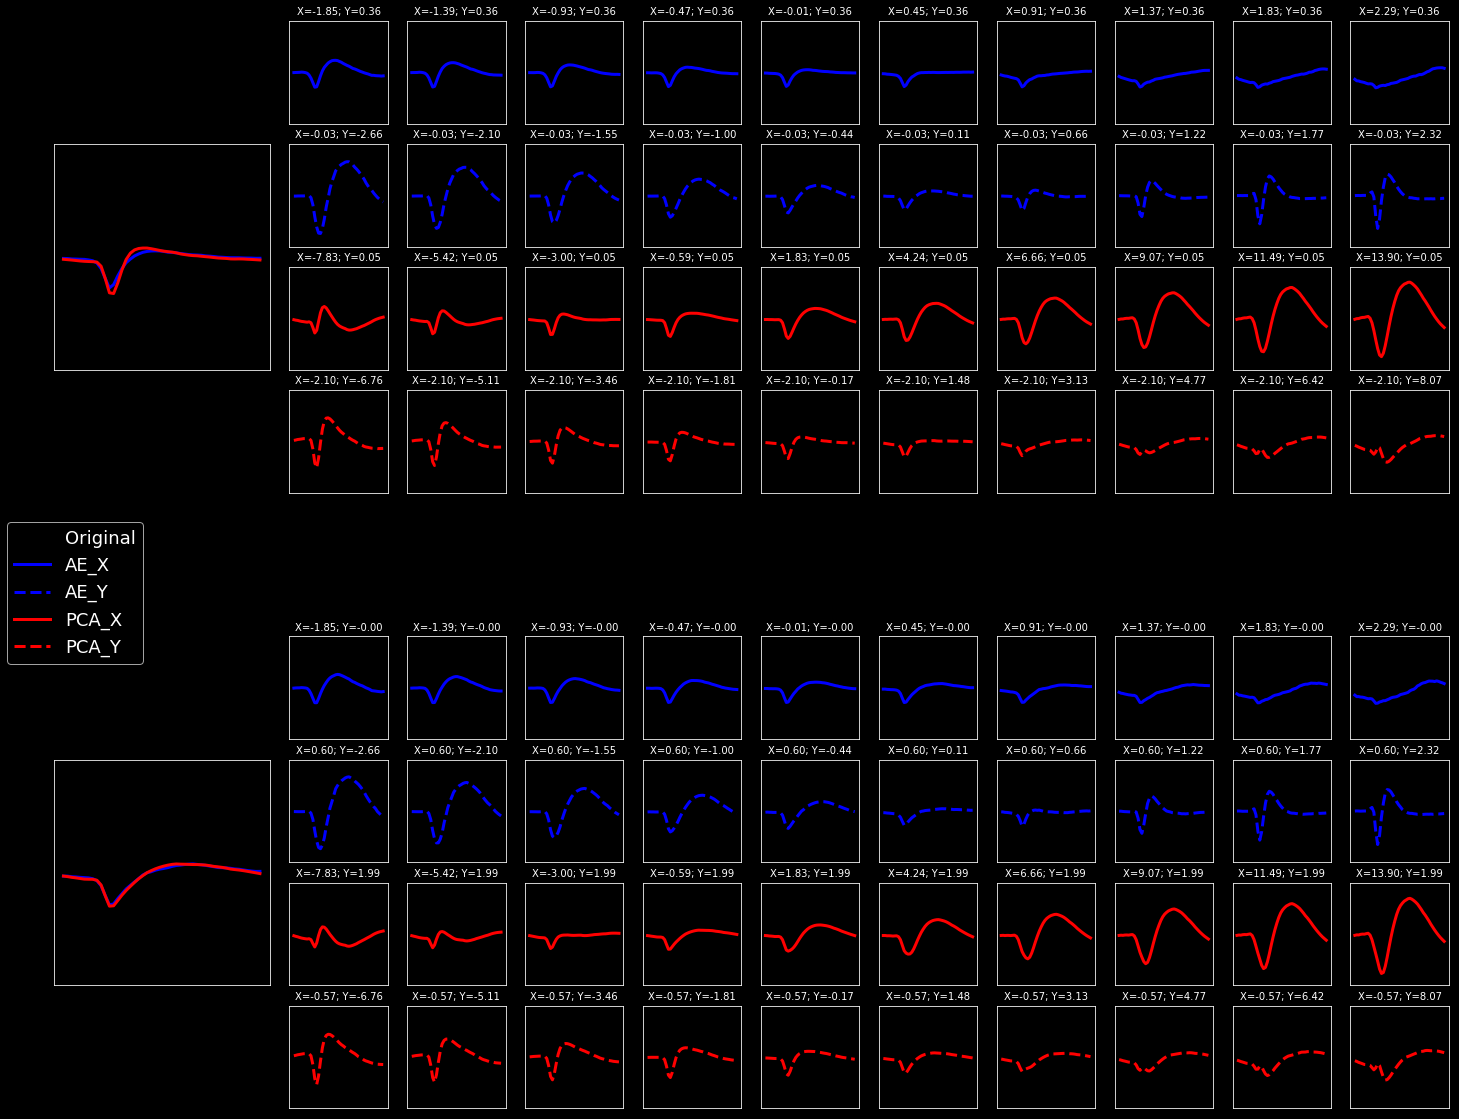

In [26]:
# to re-run the above plots
plot_loss()
model_out, pca_out, pca = pca_comp()
min_max_model, min_max_pca = wave_generation(model_out, pca_out, pca)
plot_features(min_max_model, min_max_pca)

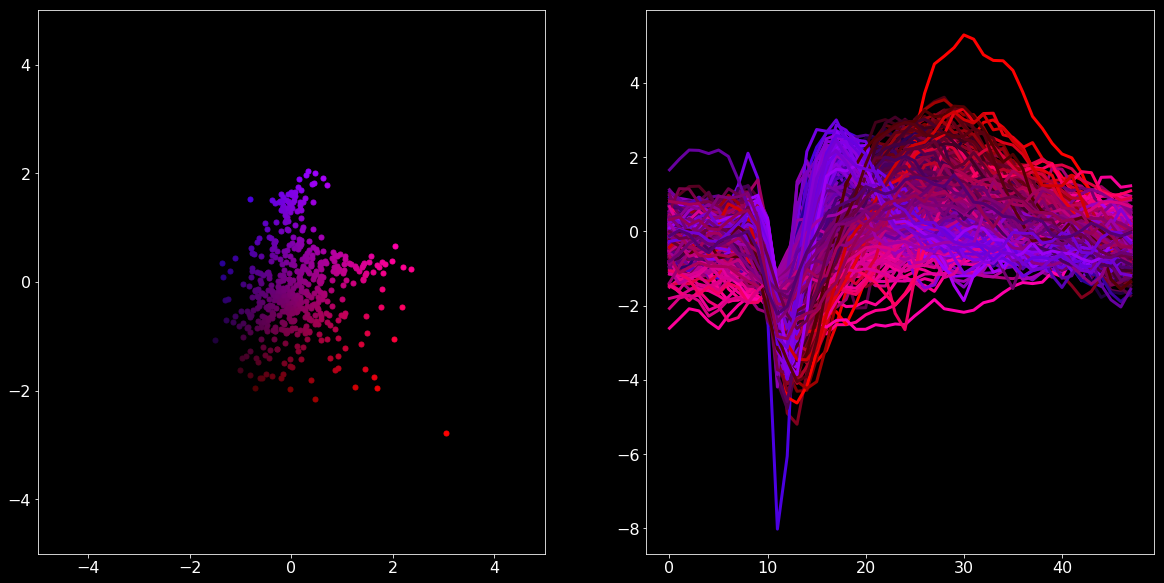

In [28]:
# Adding a new plot to see if this improves spike clustering.
# With a basic threshold across horizontal and vertical dimensions, 
# we can clearly see good waveform separations. At this point adding
# a clustering metric is trivial. 
lims = (-5,5)
threshold = 2.

fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(121, xlim=lims, ylim=lims)
ax2 = plt.subplot(122)
for id, pair in enumerate(capacity_trained[:,:]):
    
    colormap_r = np.clip((pair[0]+threshold)/(2*threshold),0,1)
    colormap_b = np.clip((pair[1]+threshold)/(2*threshold),0,1)
    colormap = (colormap_r,0,colormap_b,1)

    ax1.plot(pair[0], pair[1], '.', color=colormap)
    ax2.plot(examples[id,:], color=colormap);


In the paper $\beta$ is renamed $\gamma$ and capacity is defined as C. 

**How to Tune Hyperparameters Gamma and C? (Response by Christopher P. Burgess)**

Gamma sets the strength of the penalty for deviating from the target KL, C. Here you want to tune this such that the (batch) average KL stays close to C (say within < 1 nat) across the range of C that you use. This exact value doesn't usually matter much, but just avoid it being too high such that it destabilises the optimisation. C itself should start from low (e.g. 0 or 1) and gradually increase to a value high enough such that reconstructions end up good quality. A good way to estimate Cmax is to train B-VAE on your dataset with a beta low enough such that reconstructions end up good quality and look at the trained model's average KL. That KL can be your Cmax because it gives you a rough guide as to the average amount of representational capacity needed to encode your dataset.


# Implementation 3 (Cont'd)

There is a completely opposite approach that is used in the LFADS paper (we'll talk about it later), which is to start at $\beta=0$, then train for a bit, and slowly ramp up the value to 1. 





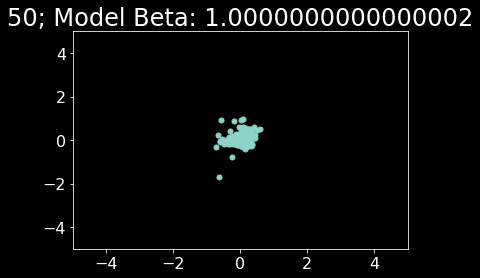

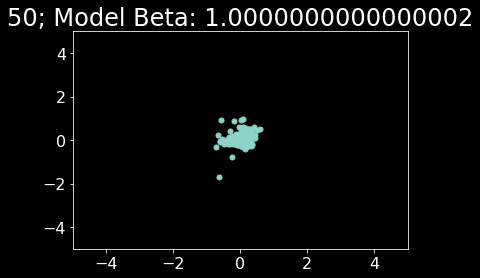

In [29]:
# from the LFADS paper they start with beta = 0 and slowly increase (KL WARMUP)

from IPython import display
import time
# Model Creation
# Model parameters
ADD_NOISE = False 
BETA_EPOCHS = 50
BETA = 0.  
BETA_MAX = 1.
BETA_START = 10  # start increasing BETA at epoch 10
BETA_ANN = 20  # increase for 20 epochs
BETA_STEP = 1  # increase at each step

BATCH_SIZE = 1024  
LEARNING_RATE = 1e-2
EPOCHS = 1
model = betaCVAE(learning_rate=LEARNING_RATE, beta=BETA, capacity=0., latent_dim=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Dataset creation
TRAIN_BUF = train_set.shape[0]
VALID_BUF = valid_set.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_set).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_set).shuffle(VALID_BUF).batch(BATCH_SIZE)

# Trackers
train_loss = []
valid_loss = []
train_time = []
valid_time = []
recon_loss = []
latent_loss = []

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
line = ax.plot(0,0,'.')

n_to_plot = 500
examples = get_examples(n_to_plot, ADD_NOISE)

for x in range(BETA_EPOCHS+1):
    if x % BETA_STEP == 0 and x > BETA_START and x <= BETA_START + BETA_ANN :
        model.beta += BETA_MAX / (BETA_ANN / BETA_STEP)

    train_model(ADD_NOISE, out_losses=True);
    capacity_trained = model.encode(examples)[0].numpy().squeeze()
    line[0].set_xdata(capacity_trained[:,0])
    line[0].set_ydata(capacity_trained[:,1])
    ax.set_title(str(x) + '; Model Beta: ' + str(model.beta))
    display.clear_output()
    display.display(plt.gcf())
    time.sleep(.001) 
  

# Informative blog posts and further reading

## ($\beta$)(V)AE

[AE in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

[AE](https://www.jeremyjordan.me/autoencoders/)

[VAE](https://www.jeremyjordan.me/variational-autoencoders/)

[VAE to BVAE](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)

[$\beta$-VAE and disentanglement](https://towardsdatascience.com/what-a-disentangled-net-we-weave-representation-learning-in-vaes-pt-1-9e5dbc205bd1)

## (de)Convolution
[Convolution arithmetic](http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html)

[Deconvolution vs upsampling and convolution](https://distill.pub/2016/deconv-checkerboard/)


## Loss functions
[Binary cross-entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

[Entropy, MLE, NLL](https://jhui.github.io/2017/01/05/Deep-learning-Information-theory/)

[VAE Demo](https://github.com/omerbsezer/Generative_Models_Tutorial_with_Demo#whatisGM)

## General Tips
[Training tips](https://karpathy.github.io/2019/04/25/recipe/)


## Research papers (same as ppt)
[Deep neural network with weight sparsity control and pre-training extracts hierarchical features and enhances classification performance: Evidence from whole-brain resting-state functional connectivity patterns of schizophrenia.](https://www.ncbi.nlm.nih.gov/pubmed/25987366)

[Latent feature representation with stacked auto-encoder for AD/MCI diagnosis.](https://www.ncbi.nlm.nih.gov/pubmed/24363140)

[A Stacked Sparse Autoencoder-Based Detector for Automatic Identification of Neuromagnetic High Frequency Oscillations in Epilepsy.](https://www.ncbi.nlm.nih.gov/pubmed/29994761)

[Stacked Autoencoders for the P300 Component Detection.](https://www.ncbi.nlm.nih.gov/pubmed/28611579)

[Semi-supervised Stacked Label Consistent Autoencoder for Reconstruction and Analysis of Biomedical Signals.](https://www.ncbi.nlm.nih.gov/pubmed/27893378)

[A stacked contractive denoising auto-encoder for ECG signal denoising.](https://www.ncbi.nlm.nih.gov/pubmed/27869101)

[Automatic Sleep Stage Scoring Using Time-Frequency Analysis and Stacked Sparse Autoencoders.](https://www.ncbi.nlm.nih.gov/pubmed/26464268)

[Feature extraction with stacked autoencoders for epileptic seizure detection.](https://www.ncbi.nlm.nih.gov/pubmed/25570914)

[A novel deep learning approach for classification of EEG motor imagery signals.](https://www.ncbi.nlm.nih.gov/pubmed/27900952)

[Inter-subject transfer learning with an end-to-end deep convolutional neural network for EEG-based BCI.](https://www.ncbi.nlm.nih.gov/pubmed/30524056)